<a href="https://colab.research.google.com/github/shree180103/food_vision_mini/blob/main/food_vision_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [212]:
import torch
from torch import nn


In [213]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# get data

First things first we need some data.

And like any good cooking show, some data has already been prepared for us.

We're going to start small.

Because we're not looking to train the biggest model or use the biggest dataset yet.

Machine learning is an iterative process, start small, get something working and increase when necessary.

The data we're going to be using is a subset of the Food101 dataset.

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Can you think of 101 different foods?

Can you think of a computer program to classify 101 foods?

I can.

A machine learning model!

Specifically, a PyTorch computer vision model like we covered in notebook 03.

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:

Original Food101 dataset and paper website.
torchvision.datasets.Food101 - the version of the data I downloaded for this notebook.
extras/04_custom_data_creation.ipynb - a notebook I used to format the Food101 dataset to use for this notebook.
data/pizza_steak_sushi.zip - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.
Let's write some code to download the formatted data from GitHub.

Note: The dataset we're about to use has been pre-formatted for what we'd like to use it for. However, you'll often have to format your own datasets for whatever problem you're working on. This is a regular practice in the machine learning world.

In [214]:
import requests
import zipfile
from pathlib import Path

# set up to a data folder
data_path=Path("data/")
image_path=data_path/ "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exits...skipping download ")
else:
  print(f" {image_path} does not exist.... crearing one ")
  image_path.mkdir(parents=True,exist_ok=True)

# download pizza sushi and steak data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading pizza steak and sudhi data ")
  f.write(request.content)

#unzip data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("unzipping pizza steak and sushi data")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi already exits...skipping download 
downloading pizza steak and sudhi data 
unzipping pizza steak and sushi data


# data prep


In [215]:
import os
def walk_thru_dirc(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} dircectories and {len(filenames)} images in {dirpath}")


In [216]:
walk_thru_dirc(image_path)

there are 2 dircectories and 0 images in data/pizza_steak_sushi
there are 3 dircectories and 0 images in data/pizza_steak_sushi/train
there are 0 dircectories and 78 images in data/pizza_steak_sushi/train/pizza
there are 0 dircectories and 75 images in data/pizza_steak_sushi/train/steak
there are 0 dircectories and 72 images in data/pizza_steak_sushi/train/sushi
there are 3 dircectories and 0 images in data/pizza_steak_sushi/test
there are 0 dircectories and 25 images in data/pizza_steak_sushi/test/pizza
there are 0 dircectories and 19 images in data/pizza_steak_sushi/test/steak
there are 0 dircectories and 31 images in data/pizza_steak_sushi/test/sushi


In [217]:
# training and test path
train_dir=image_path/ "train"
test_dir=image_path/ "test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [218]:
# visualize an img
import random
from PIL import Image

random.seed(42)

#get all the img paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

image_path_list



[PosixPath('data/pizza_steak_sushi/train/pizza/853441.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/618348.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2687575.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3441394.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/29417.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/741883.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1285298.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/138855.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/764429.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2924941.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2330965.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2800325.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/786995.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1008844.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/739735.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2760984.jpg'),
 PosixPath('data/

In [219]:
# pick a random img path
# random.seed(42)
random_image_path=random.choice(image_path_list)

print(random_image_path)

# get image class from path name (the img class is the name of the dircetory where the img is stored)
image_class=random_image_path.parent.stem

print(image_class)


data/pizza_steak_sushi/train/pizza/3281494.jpg
pizza


Random image path:data/pizza_steak_sushi/train/pizza/3281494.jpg
Image class:pizza
Image height:288
Image width:512


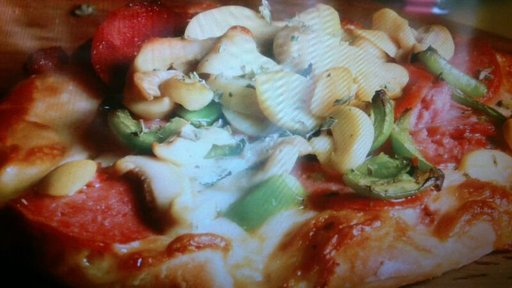

In [220]:
img=Image.open(random_image_path)
print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image height:{img.height}")
print(f"Image width:{img.width}")
img

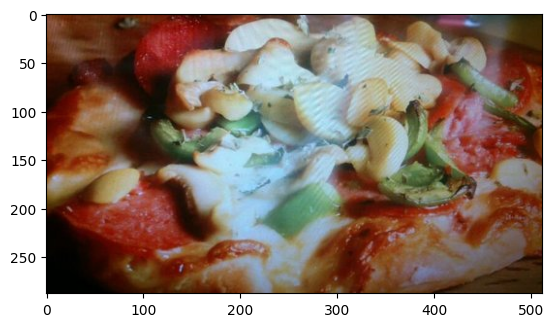

In [221]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(img)

(288, 512, 3)


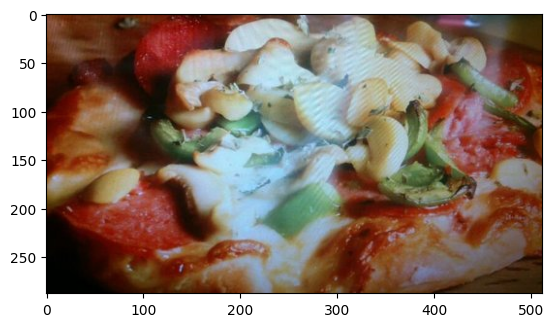

In [222]:
img_as_arr=np.asarray(img)
print(img_as_arr.shape)
plt.imshow(img_as_arr)

In [223]:
# tranforming imgs into tensors

from torch.utils.data import DataLoader
from torchvision import datasets,transforms


In [224]:
data_transform=transforms.Compose(transforms=[transforms.Resize(size=(64,64)),transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor()])


In [225]:
data_transform(img).shape

torch.Size([3, 64, 64])

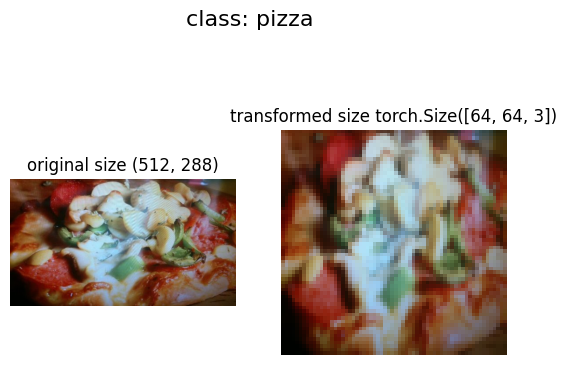

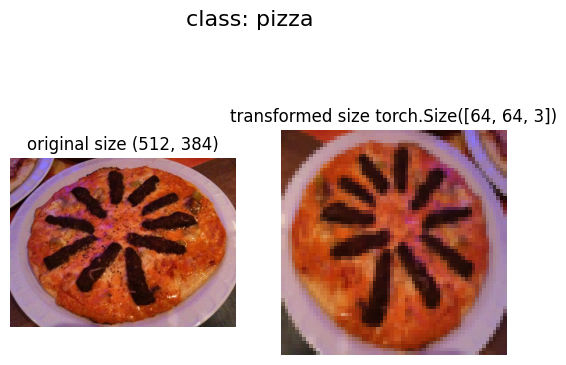

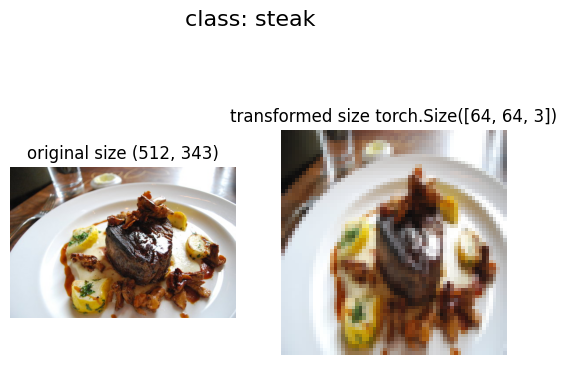

In [226]:
def plot_transformed_imgs(image_paths,transform,n=3,seed=None):
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n) # Changed image_path to image_paths
  for img_path in random_image_paths:
    with Image.open(img_path) as f: # Changed image_path to img_path
      fig,ax=plt.subplots(nrows=1,ncols=2) # Changed n_row to n_rows
      ax[0].imshow(f)
      ax[0].set_title(f"original size {f.size}")
      ax[0].axis('off') # Changed asxis to axis and added 'off' argument

      transformed_image=transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"transformed size {transformed_image.shape}") # Changed title to reflect transformed image
      ax[1].axis('off') # Changed asxis to axis and added 'off' argument

      fig.suptitle(f"class: {img_path.parent.stem}",fontsize=16) # Changed font_size to fontsize
plot_transformed_imgs(image_paths=image_path_list,transform=data_transform,n=3,seed=42)

#transforming all imgs


In [227]:
#option 1
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,transform=data_transform,target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [228]:
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [229]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [230]:
len(train_data),len(test_data)

(225, 75)

In [231]:
train_data[0][0].shape

torch.Size([3, 64, 64])

In [232]:
import os
os.cpu_count()

2

In [233]:
# turning loaded imgs into data loader

train_dataloader=DataLoader(dataset=train_data,batch_size=32,shuffle=True,num_workers=1) #num_workers=no.cpus used to perform task

test_dataloader=DataLoader(dataset=test_data,batch_size=32,shuffle=False,num_workers=1) #num_workers=no.cpus used to perform task

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff56710d780>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff56710dc00>)

In [234]:
len(train_dataloader),len(test_dataloader)

(8, 3)

In [235]:
img,label=next(iter(train_dataloader))
img.shape,label

(torch.Size([32, 3, 64, 64]),
 tensor([1, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 0, 1, 0, 2, 0, 2, 1, 0, 1, 1, 1, 0, 2,
         1, 2, 1, 2, 2, 0, 2, 0]))

# Data Augmentation

In [236]:
# lets look at trivial aygment

from torchvision import disable_beta_transforms_warning

train_transform=transforms.Compose(transforms=[transforms.Resize(size=(64,64)),transforms.TrivialAugmentWide(num_magnitude_bins=31),transforms.ToTensor()])# 31 indicates intensity of augment (here aument is of an high lvl)

test_transform=transforms.Compose(transforms=[transforms.Resize(size=(64,64)),transforms.ToTensor()])


In [237]:
train_data=datasets.ImageFolder(root=train_dir,transform=train_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,transform=test_transform,target_transform=None)

train_dataloader=DataLoader(dataset=train_data,batch_size=32,shuffle=True,num_workers=1)
test_dataloader=DataLoader(dataset=test_data,batch_size=32,shuffle=False,num_workers=1)

In [238]:
image_path_list=list(image_path.glob("*/*/*.jpg"))

image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/853441.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/618348.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2687575.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3441394.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/29417.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/741883.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1285298.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/138855.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/764429.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2924941.jpg')]

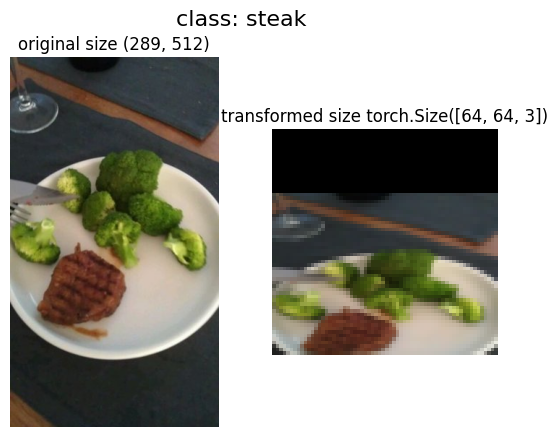

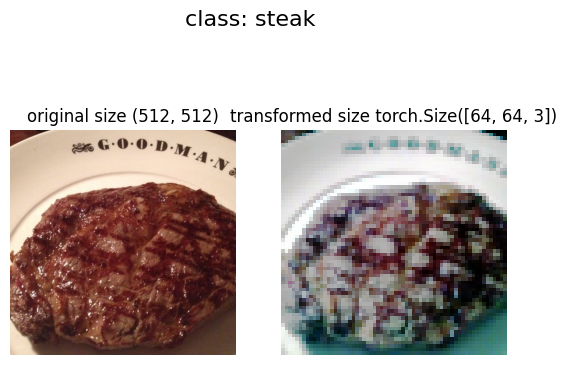

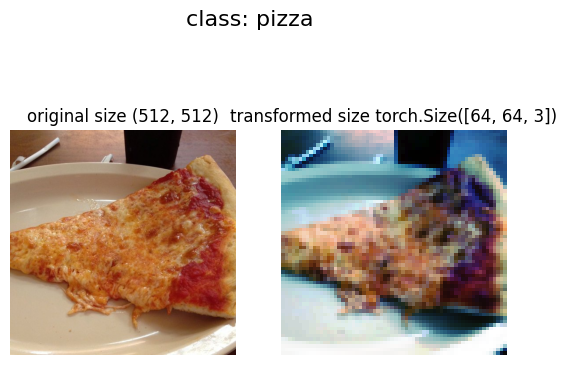

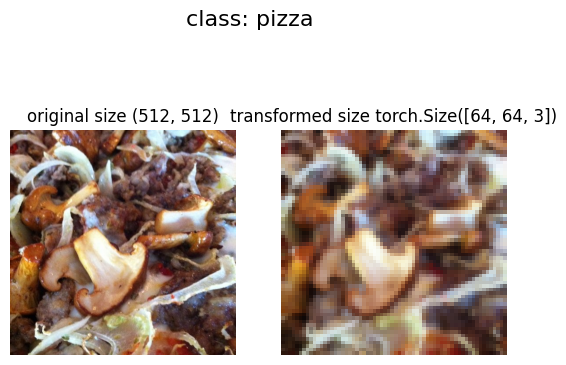

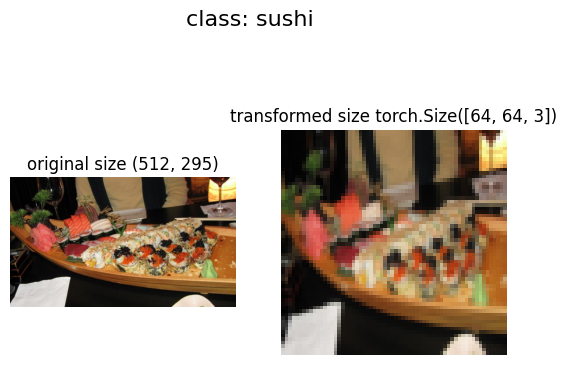

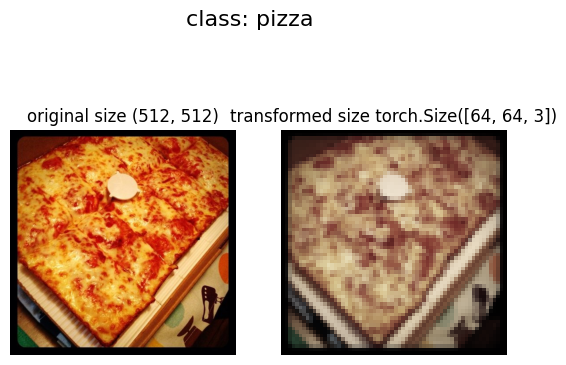

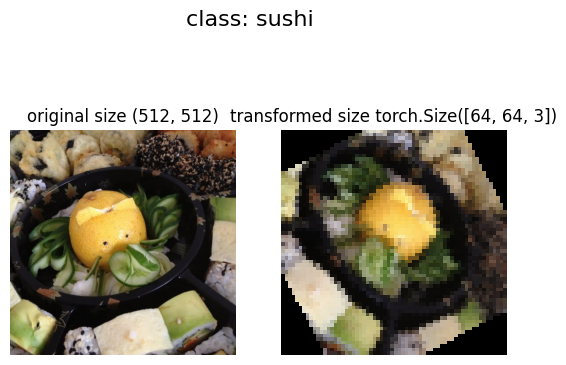

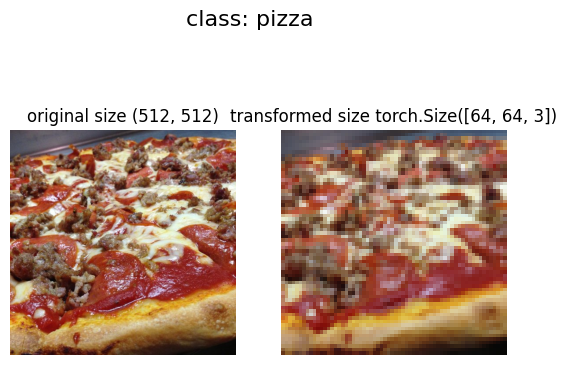

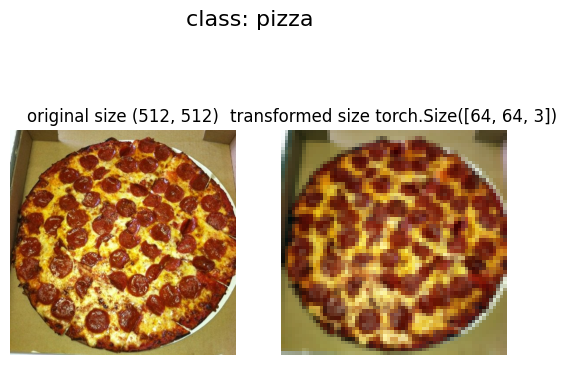

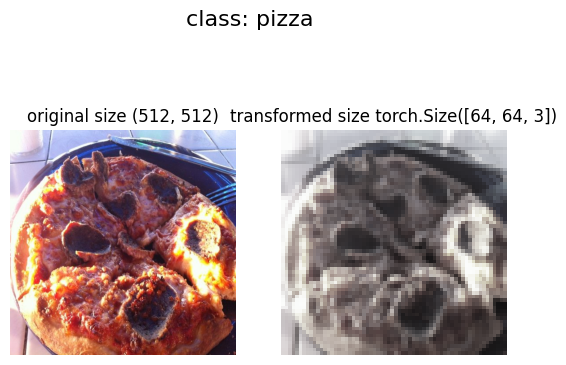

In [239]:
plot_transformed_imgs(image_paths=image_path_list,transform=train_transform,n=10,seed=None)

#model without data augmentation

In [240]:
# creating simple transform
simple_transform=transforms.Compose(transforms=[transforms.Resize(size=(64,64)),transforms.ToTensor()])

In [241]:
train_data_simple=datasets.ImageFolder(root=train_dir,transform=simple_transform)
test_data_simple=datasets.ImageFolder(root=test_dir,transform=simple_transform)

# turn dataset into dataloader

train_dataloader_simple=DataLoader(dataset=train_data_simple,batch_size=32,shuffle=True,num_workers=os.cpu_count())
test_dataloader_simple=DataLoader(dataset=test_data_simple,batch_size=32,shuffle=False,num_workers=os.cpu_count())

In [242]:
len(train_dataloader_simple),len(test_dataloader_simple)

(8, 3)

In [243]:
#model without data augmentation
class Food_model(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.conv_block1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )

    self.conv_block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )

    self.Classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,out_features=output_shape)
    )

  def forward(self,x):
    x=self.conv_block1(x)
    # print(x.shape)
    x=self.conv_block2(x)
    # print(x.shape)
    x=self.Classifier(x)
    # print(x.shape)

    return x




In [244]:
torch.manual_seed(42)
model1=Food_model(input_shape=3,hidden_units=10,output_shape=len(class_names))
model1


Food_model(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [245]:
img,label=next(iter(train_dataloader_simple))
model1(img)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [246]:
!pip install torchinfo

In [247]:
from torchinfo import summary

summary(model1,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
Food_model                               [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [263]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model1.parameters(),lr=0.1)

In [249]:
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [264]:
# creating train_step

def train_step(model:nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:nn.Module,optimizer:torch.optim.Optimizer,acc_fn=acc_fn):
  train_loss,train_acc=0,0
  for batch,(x,y) in enumerate(data_loader):
    model.train()

    y_pred=model(x)
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    train_acc+=acc_fn(y,y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  return train_loss,train_acc







In [265]:
# creating test step

def test_step(model:nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:nn.Module,acc_fn=acc_fn):
  model.eval()
  test_loss,test_acc=0,0
  with torch.inference_mode():
    for batch,(x_test,y_test) in enumerate(data_loader):
      y_pred=model(x_test)
      test_loss=loss_fn(y_pred,y_test).item()
      test_acc+=acc_fn(y_test,y_pred.argmax(dim=1))

  test_loss/=len(data_loader)
  test_acc/=len(data_loader)
  return test_loss,test_acc



In [266]:
## create a train and test func
from tqdm.auto import tqdm

def train_and_test(model:nn.Module,train_data_loader:torch.utils.data.DataLoader,
                   test_data_loader:torch.utils.data.DataLoader
                   ,loss_fn:nn.Module,optimizer:torch.optim.Optimizer,acc_fn=acc_fn,epochs:int=5):

  results={"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}

  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model,train_dataloader,loss_fn,optimizer,acc_fn)
    test_loss,test_acc=test_step(model,test_dataloader,loss_fn,acc_fn)

    print(f"epoch:{epoch} | train loss:{train_loss:.4f} | train acc:{train_acc:.4f}% | test loss:{test_loss:.4f} | test acc:{test_acc:.4f}% ")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [267]:
torch.manual_seed(42)
model_results=train_and_test(model=model1,train_data_loader=train_dataloader_simple,test_data_loader=test_dataloader_simple,loss_fn=loss_fn,optimizer=optimizer,acc_fn=acc_fn,
               epochs=5)
model_results

  0%|          | 0/5 [00:00<?, ?it/s]

epoch:0 | train loss:42.8303 | train acc:34.3750% | test loss:0.2453 | test acc:54.1667% 
epoch:1 | train loss:1.1366 | train acc:28.1250% | test loss:0.3054 | test acc:54.1667% 
epoch:2 | train loss:1.0851 | train acc:40.2344% | test loss:0.4130 | test acc:26.0417% 
epoch:3 | train loss:1.1200 | train acc:30.4688% | test loss:0.4710 | test acc:26.0417% 
epoch:4 | train loss:1.0998 | train acc:30.0781% | test loss:0.4740 | test acc:26.0417% 


{'train_loss': [42.830315589904785,
  1.13664710521698,
  1.0850557535886765,
  1.1199592649936676,
  1.0997838973999023],
 'train_acc': [34.375, 28.125, 40.234375, 30.46875, 30.078125],
 'test_loss': [0.24526292085647583,
  0.30544336636861164,
  0.41304337978363037,
  0.47103404998779297,
  0.47402767340342206],
 'test_acc': [54.166666666666664,
  54.166666666666664,
  26.041666666666668,
  26.041666666666668,
  26.041666666666668]}

In [268]:
def plot_loss_cusrves(results:dict[str,list[float]]):
  loss=results["train_loss"]
  test_loss=results["test_loss"]

  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  epochs=range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("loss")
  plt.xlabel("epochs")

  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")

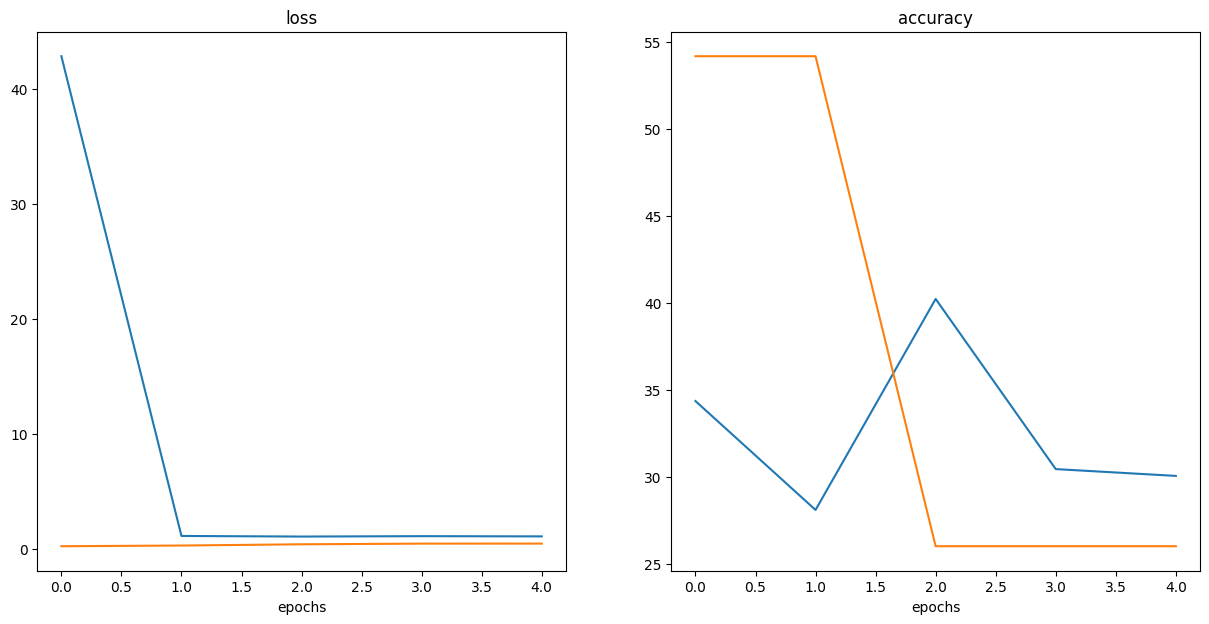

In [269]:
plot_loss_cusrves(model_results)

In [270]:
train_data_augmented=datasets.ImageFolder(root=train_dir,transform=train_transform,target_transform=None)


In [271]:
from torch.utils.data import DataLoader
train_dataloader_augmented=DataLoader(dataset=train_data_augmented,batch_size=32,shuffle=True,num_workers=2)



In [272]:
model2=Food_model(input_shape=3,hidden_units=10,output_shape=len(train_data_augmented.classes))
model2

Food_model(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [273]:
torch.manual_seed(42)
model2_results=train_and_test(model=model2,train_data_loader=train_dataloader_augmented,
                              test_data_loader=test_dataloader_simple,
                              loss_fn=loss_fn,optimizer=optimizer,epochs=5)


  0%|          | 0/5 [00:00<?, ?it/s]

epoch:0 | train loss:1.1013 | train acc:28.1250% | test loss:0.3611 | test acc:54.1667% 
epoch:1 | train loss:1.1011 | train acc:28.1250% | test loss:0.3611 | test acc:54.1667% 
epoch:2 | train loss:1.1011 | train acc:28.1250% | test loss:0.3611 | test acc:54.1667% 
epoch:3 | train loss:1.0993 | train acc:28.1250% | test loss:0.3611 | test acc:54.1667% 
epoch:4 | train loss:1.1014 | train acc:28.1250% | test loss:0.3611 | test acc:54.1667% 


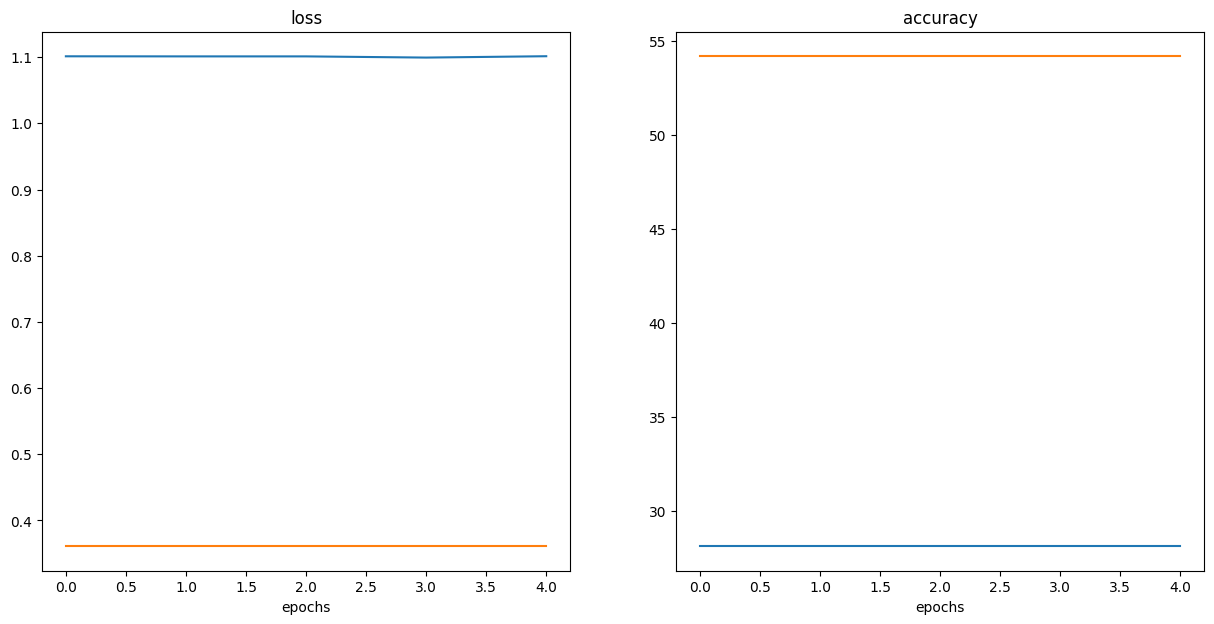

In [274]:
plot_loss_cusrves(model2_results)